In [41]:
## Part A

In [7]:
import pandas as pd
from pandas import Series
from pandas import DataFrame
import numpy as np
%pylab inline
import nltk
from nltk import bigrams
from nltk import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import matplotlib.pyplot as plt
import re

Populating the interactive namespace from numpy and matplotlib


In [8]:
salary_data = pd.read_csv("Train_rev1.csv")

In [4]:
# A1

descriptions = salary_data["FullDescription"][0:1000]
descriptions = descriptions.str.decode("utf-8")
clean_descriptions = []
for desc in descriptions:
    clean_descriptions.append(desc)
clean_descriptions2 = " ".join(clean_descriptions)

In [5]:
tokens = nltk.word_tokenize(clean_descriptions2)

In [6]:
pos_tags = nltk.pos_tag(tokens)

KeyboardInterrupt: 

In [50]:
pos_list = [tag[1] for tag in pos_tags]

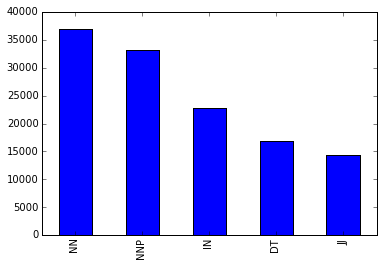

In [51]:
Series(pos_list).value_counts()[:5].plot(kind='bar')

In [52]:
# A2

word_list = [word[0].lower() for word in pos_tags]
word_list = Series(word_list)

In [53]:
isalpha_mask = [word.isalpha() for word in word_list]

In [54]:
word_list_clean = word_list[isalpha_mask]

In [55]:
frequencies = list(word_list_clean.value_counts()[:100])

In [56]:
ranks = [rank+1 for rank in range(100)]

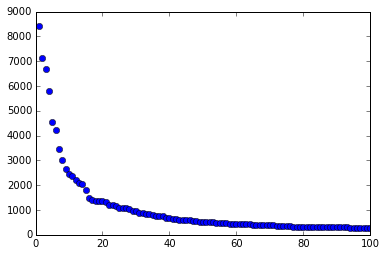

In [57]:
plt.plot(ranks, frequencies, 'ro', color="blue")

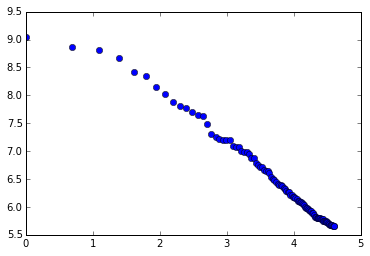

In [58]:
plt.plot([math.log(rank) for rank in ranks], [math.log(freq) for freq in frequencies], 'ro', color="blue")

In [59]:
# A3

nostop = [w for w in word_list_clean if not w in stopwords.words('english')]

In [61]:
lmtzr = WordNetLemmatizer()
nostoplmtzed = [lmtzr.lemmatize(w) for w in nostop]

In [63]:
nostoplmtzed = Series(nostoplmtzed)
nostoplmtzed.value_counts()[:10]

care          3060
home          2117
experience    1366
manager       1276
nurse         1266
work          1201
nursing       1180
support       1093
within        1040
working        965
dtype: int64

In [64]:
## Part B

In [9]:
import random
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from operator import itemgetter

In [10]:
# B1

np.random.seed(1234567)
salaries = salary_data['SalaryNormalized']
threshold = np.percentile(salaries, 75)

In [11]:
salary_data['High'] = 0.0

In [12]:
high_mask = salary_data['SalaryNormalized'] >= threshold

In [13]:
salary_data.ix[high_mask,'High'] = 1

In [14]:
highs = salary_data[high_mask]

In [15]:
low_mask = salary_data['High'] == 0

In [16]:
lows = salary_data[low_mask]

In [17]:
sample_highs = highs.sample(7500, replace=False).copy()

In [18]:
sample_lows = lows.sample(7500, replace=False).copy()

In [19]:
sample = sample_highs.append(sample_lows, ignore_index=False, verify_integrity=True)

In [20]:
train = sample.sample(0.6*len(sample), replace=False).copy()

In [21]:
test = sample[~sample.index.isin(train.index.values)]

In [22]:
train_x = train['FullDescription']
train_y = train['High']

In [23]:
test_x = test['FullDescription']
test_y = test['High']

In [24]:
vectorizer = TfidfVectorizer(min_df=2, smooth_idf=True, strip_accents='unicode', norm='l2')

In [25]:
all_train_x = vectorizer.fit_transform(train_x)
all_test_x = vectorizer.transform(test_x)

In [26]:
all_nb_classifier = MultinomialNB().fit(all_train_x, train_y)

In [27]:
all_y_nb_predicted = all_nb_classifier.predict(all_test_x)

In [28]:
metrics.confusion_matrix(test_y, all_y_nb_predicted)

array([[2223,  710],
       [ 550, 2517]])

In [29]:
all_predict_y = Series(all_y_nb_predicted).reset_index()

In [30]:
all_predict_y = all_predict_y[0]

In [31]:
all_df = pd.DataFrame()

In [32]:
all_df['Predicted'] = all_predict_y

In [33]:
all_df['Actual'] = test_y.reset_index()['High']

In [34]:
pd.crosstab(index=all_df['Actual'], columns=all_df['Predicted'])

Predicted,0.0,1.0
Actual,,
0,2223,710
1,550,2517


In [38]:
pd.crosstab(index=all_df['Actual'], columns=all_df['Predicted']).apply(lambda r: r/r.sum(), axis=1)

Predicted,0.0,1.0
Actual,,
0,0.757927,0.242073
1,0.179328,0.820672


In [36]:
(all_df['Predicted'] == all_df['Actual']).mean()

0.79000000000000004

In [40]:
# B2

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

In [41]:
lemma_vectorizer = TfidfVectorizer(min_df=0, smooth_idf=True, strip_accents='unicode', norm='l2', tokenizer=LemmaTokenizer())

In [42]:
lemma_train_x = lemma_vectorizer.fit_transform(train_x)
lemma_test_x = lemma_vectorizer.transform(test_x)

In [43]:
lemma_nb_classifier = MultinomialNB().fit(lemma_train_x, train_y)

In [44]:
lemma_y_nb_predicted = lemma_nb_classifier.predict(lemma_test_x)

In [45]:
lemma_predict_y = Series(lemma_y_nb_predicted).reset_index()
lemma_predict_y = lemma_predict_y[0]
lemma_df = pd.DataFrame()
lemma_df['Predicted'] = lemma_predict_y
lemma_df['Actual'] = test_y.reset_index()['High']
pd.crosstab(index=lemma_df['Actual'], columns=lemma_df['Predicted'])

Predicted,0.0,1.0
Actual,,
0,2217,716
1,551,2516


In [46]:
pd.crosstab(index=lemma_df['Actual'], columns=lemma_df['Predicted']).apply(lambda r: r/r.sum(), axis=1)

Predicted,0.0,1.0
Actual,,
0,0.755881,0.244119
1,0.179654,0.820346


In [47]:
(lemma_df['Predicted'] == lemma_df['Actual']).mean()

0.78883333333333339

In [48]:
# B3

stop_vectorizer = \
TfidfVectorizer(min_df=0, smooth_idf=True, strip_accents='unicode',\
                norm='l2', stop_words="english")

In [49]:
stop_train_x = stop_vectorizer.fit_transform(train_x)
stop_test_x = stop_vectorizer.transform(test_x)

In [50]:
stop_nb_classifier = MultinomialNB().fit(stop_train_x, train_y)

In [51]:
stop_y_nb_predicted = stop_nb_classifier.predict(stop_test_x)

In [52]:
stop_predict_y = Series(stop_y_nb_predicted).reset_index()
stop_predict_y = stop_predict_y[0]
stop_df = pd.DataFrame()
stop_df['Predicted'] = stop_predict_y
stop_df['Actual'] = test_y.reset_index()['High']
pd.crosstab(index=stop_df['Actual'], columns=stop_df['Predicted'])

Predicted,0.0,1.0
Actual,,
0,2211,722
1,519,2548


In [53]:
pd.crosstab(index=stop_df['Actual'], columns=stop_df['Predicted']).apply(lambda r: r/r.sum(), axis=1)

Predicted,0.0,1.0
Actual,,
0,0.753836,0.246164
1,0.169221,0.830779


In [54]:
(stop_df['Predicted'] == stop_df['Actual']).mean()

0.79316666666666669

In [60]:
# Top 10 words most indicative of high salary
N = 10
vocabulary = np.array([t for t, i in sorted(stop_vectorizer.vocabulary_.iteritems(), key=itemgetter(1))])
topN = np.argsort(stop_nb_classifier.coef_[0])[-N:]
" ".join(vocabulary[topN])

u'skills client development manager team role project management business experience'

In [62]:
# Top 10 words most indicative of low salary
bottomN = np.argsort(stop_nb_classifier.coef_[0])[:10]
" ".join(vocabulary[bottomN])

u'kingswodd martins martinmetalent martinamaidayrecruit martina counsellors martigprs marta marsworth marston'

In [64]:
# IGNORE

train_highs = train[train['High']==1]
train_highs_x = train_highs['FullDescription']
train_highs_y = train_highs['High']

test_highs = test[test['High']==1]
test_highs_x = test_highs['FullDescription']
test_highs_y = test_highs['High']

train_lows = train[train['High']==0]
train_lows_x = train_lows['FullDescription']
train_lows_y = train_lows['High']

test_lows = test[test['High']==0]
test_lows_x = test_lows['FullDescription']
test_lows_y = test_lows['High']

In [65]:
# Top 10 words most indicative of high salary
stop_train_highs_x = stop_vectorizer.fit_transform(train_highs_x)
stop_test_highs_x = stop_vectorizer.transform(test_highs_x)

In [66]:
stop_highs_nb_classifier = MultinomialNB().fit(stop_train_highs_x, train_highs_y)

In [67]:
N = 10
highs_vocabulary = np.array([t for t, i in sorted(stop_vectorizer.vocabulary_.iteritems(), key=itemgetter(1))])
highs_topN = np.argsort(stop_highs_nb_classifier.coef_[0])[-N:]
" ".join(highs_vocabulary[highs_topN])

u'skills work development project manager team role management business experience'

In [68]:
# Top 10 words most indicative of low salary
stop_train_lows_x = stop_vectorizer.fit_transform(train_lows_x)
stop_test_lows_x = stop_vectorizer.transform(test_lows_x)

In [69]:
stop_lows_nb_classifier = MultinomialNB().fit(stop_train_lows_x, train_lows_y)

In [70]:
lows_vocabulary = np.array([t for t, i in sorted(stop_vectorizer.vocabulary_.iteritems(), key=itemgetter(1))])
lows_topN = np.argsort(stop_lows_nb_classifier.coef_[0])[-N:]
" ".join(lows_vocabulary[lows_topN])

u'client working manager skills team business work role sales experience'

In [71]:
# B4

class posBigram(object):
    def __init__(self):
        pass
    def __call__(self,doc):
      return nltk.Text(nltk.bigrams([i[1] for i in nltk.pos_tag(nltk.word_tokenize(doc))]))

In [72]:
pos_bigram_vectorizer = TfidfVectorizer(min_df=0, smooth_idf=True, strip_accents='unicode', norm='l2', tokenizer=posBigram())

In [73]:
pos_bigram_train_x = pos_bigram_vectorizer.fit_transform(train_x) #defines dictionary

In [74]:
pos_bigram_nb_classifier = MultinomialNB().fit(pos_bigram_train_x, train_y)

In [75]:
pos_bigram_test_x = pos_bigram_vectorizer.transform(test_x)

In [76]:
pos_bigram_y_nb_predicted = pos_bigram_nb_classifier.predict(pos_bigram_test_x)

In [77]:
pos_bigram_predict_y = Series(pos_bigram_y_nb_predicted).reset_index()
pos_bigram_predict_y = pos_bigram_predict_y[0]
pos_bigram_df = pd.DataFrame()
pos_bigram_df['Predicted'] = pos_bigram_predict_y
pos_bigram_df['Actual'] = test_y.reset_index()['High']
pd.crosstab(index=pos_bigram_df['Actual'], columns=pos_bigram_df['Predicted'])

Predicted,0.0,1.0
Actual,,
0,1925,1008
1,1175,1892


In [78]:
(pos_bigram_df['Predicted'] == pos_bigram_df['Actual']).mean()

0.63616666666666666